# Automatically parse experimental data

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import math
import joblib
import copy
from tqdm import tqdm
import warnings
import sys

In [2]:
%load_ext autoreload
%autoreload 2

# custom lib
sys.path.append("FlowMater/")
sys.path.append("IonLib/")
from graph_util import draw_graph
from ExperimentManager import ExperimentManager
from dataframe_parse import add_unique_IDs,custom_df_parse

# other settings
warnings.simplefilter('ignore')
pd.set_option('display.max_columns', 100)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

In [3]:
# automatically load and parse data in the database folder
experiment_manager = ExperimentManager(fp_numbers=30)
%time experiment_manager.auto_load()

load already parsed database
CPU times: user 707 ms, sys: 27.4 ms, total: 734 ms
Wall time: 726 ms


In [4]:
# convert experimental data into dataframe
df = copy.deepcopy(experiment_manager.dataframe)
df = custom_df_parse(df)

all_fp_keys = experiment_manager.fp_calculator.v_to_i.keys()
joblib.dump(list(all_fp_keys), "temp/all_fp_keys.bin")
cond_label = "Log ionic conductivity (S/cm)"
joblib.dump(df, "temp/df.bin")

# summarize fp list
fp_list_df = pd.DataFrame(
    [(k, v) for k, v in experiment_manager.fp_compressor.conversion_dict.items()])
fp_list_df.columns = ["Original", "Grouped"]
fp_list_df.to_csv("temp/fp_keys.csv")
df.shape

(538, 430)

# **Important**
- Before running the following cells, run "parse_****.ipynb" notebooks to parse measurement data (whenever updating the database)
- Otherwise, merging error will occur

# Load and merge parsed data
- load parsed data of ...
    - NMR spectra
    - temperature dependence of sigma
    - particle size
    - DSC

In [5]:
parsed_columns = []
parsed_path_list = [
    "temp/parsed/nmr_anal.bin",
    "temp/parsed/vtf_anal.bin",
    "temp/parsed/particle_anal.bin",
    "temp/parsed/dsc_anal.bin"
]

for parsed_path in parsed_path_list:
    parsed_dict = joblib.load(parsed_path)
    for ind in parsed_dict.keys():
        parsed_data = parsed_dict[ind]
        for k, v in parsed_data.items():
            temp = df.loc[ind]
            df.at[ind, k] = v
            parsed_columns.append(k)

    parsed_columns = list(set(parsed_columns))

In [6]:
# share different measurement data with same electrolytes
from dataframe_parse import search_corresponding_data_id

parsed_columns.extend(["DSC (salt_melting_temperature)",
                       "DSC (salt_melting_heat_energy)"])

for merge_column in tqdm(parsed_columns):
    measurement_df = df.select_dtypes(include=[float, int])
    measurement_records = measurement_df[~measurement_df[merge_column].isnull(
    )]

    for i in range(measurement_records.shape[0]):
        target_record = measurement_records.iloc[i, :]
        found_indices = search_corresponding_data_id(
            target_record, measurement_df, merge_column)

        for ind in found_indices:
            if pd.isna(df.loc[ind, merge_column]):
                df.loc[ind, merge_column] = target_record[merge_column]

100%|██████████| 17/17 [00:01<00:00, 10.62it/s]


In [7]:
# calculate median and std of conductivity for same electrolytes
from dataframe_parse import prepare_group_score_df
group_score_df = prepare_group_score_df(df, cond_label, all_fp_keys)
# plt.figure(figsize=(5,9),dpi=100)
#sns.barplot(data=group_score_df,y="manual condition",x=cond_label)

# Impute missing data
- Missing experimental data (e.g., melting enthalpy for some records) will be imputed by machine learning

In [8]:
#select mode
GROUP_SCORE_MODE = False
#GROUP_SCORE_MODE = True

if GROUP_SCORE_MODE:
    # run this code for "conductivity score" (= median - std) analysis
    target_df = group_score_df
else:
    # run this code for normal analysis
    target_df = df

    
num_df = copy.deepcopy(target_df.select_dtypes(include=[float, int]))

In [9]:
from MissParallelX import MissParallelX
import lightgbm as lgb

# remove conductivity-related parameters to avoid problem leaking
conductivity_columns = [
    cond_label
]
conductivity_columns.extend([i for i in num_df.columns if i.find("VTF") >= 0])
num_temp_df = num_df.drop(conductivity_columns, axis=1)

#impute
imputer = MissParallelX(custom_regressor=lgb.LGBMRegressor())
%time imputed_array=imputer.fit_transform(num_temp_df)

CPU times: user 5.28 s, sys: 2.81 s, total: 8.09 s
Wall time: 9.3 s


In [30]:
#process imputed dataframe

from dataframe_parse import prepare_custom_imputed_dataframe
imputed_df = copy.copy(num_temp_df)
imputed_df.iloc[:, :] = imputed_array
imputed_df[cond_label] = num_df[cond_label]

sigma_df = target_df[imputed_df.columns]
sigma_df = sigma_df[target_df[cond_label] == target_df[cond_label]]

anal_df = add_unique_IDs(sigma_df, all_fp_keys)
anal_df_rt = anal_df[anal_df["Temperature of $\sigma$$_\mathrm{ion}$ ($^\mathrm{o}$C)"]
                     == 25.01]

# make imputed dataframe for visualization
integrated_imputed_df = prepare_custom_imputed_dataframe(
    anal_df, num_df, num_temp_df, imputed_df, cond_label)
#integrated_imputed_df.to_excel("temp/imputed.xlsx")

# Analyaze conductivity
- Visualize analysis results

<AxesSubplot:xlabel='Log ionic conductivity (S/cm)', ylabel='Count'>

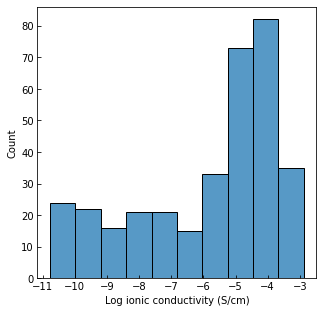

In [11]:
fig = plt.figure(figsize=(5, 5))
sns.histplot(data=sigma_df, x=cond_label)

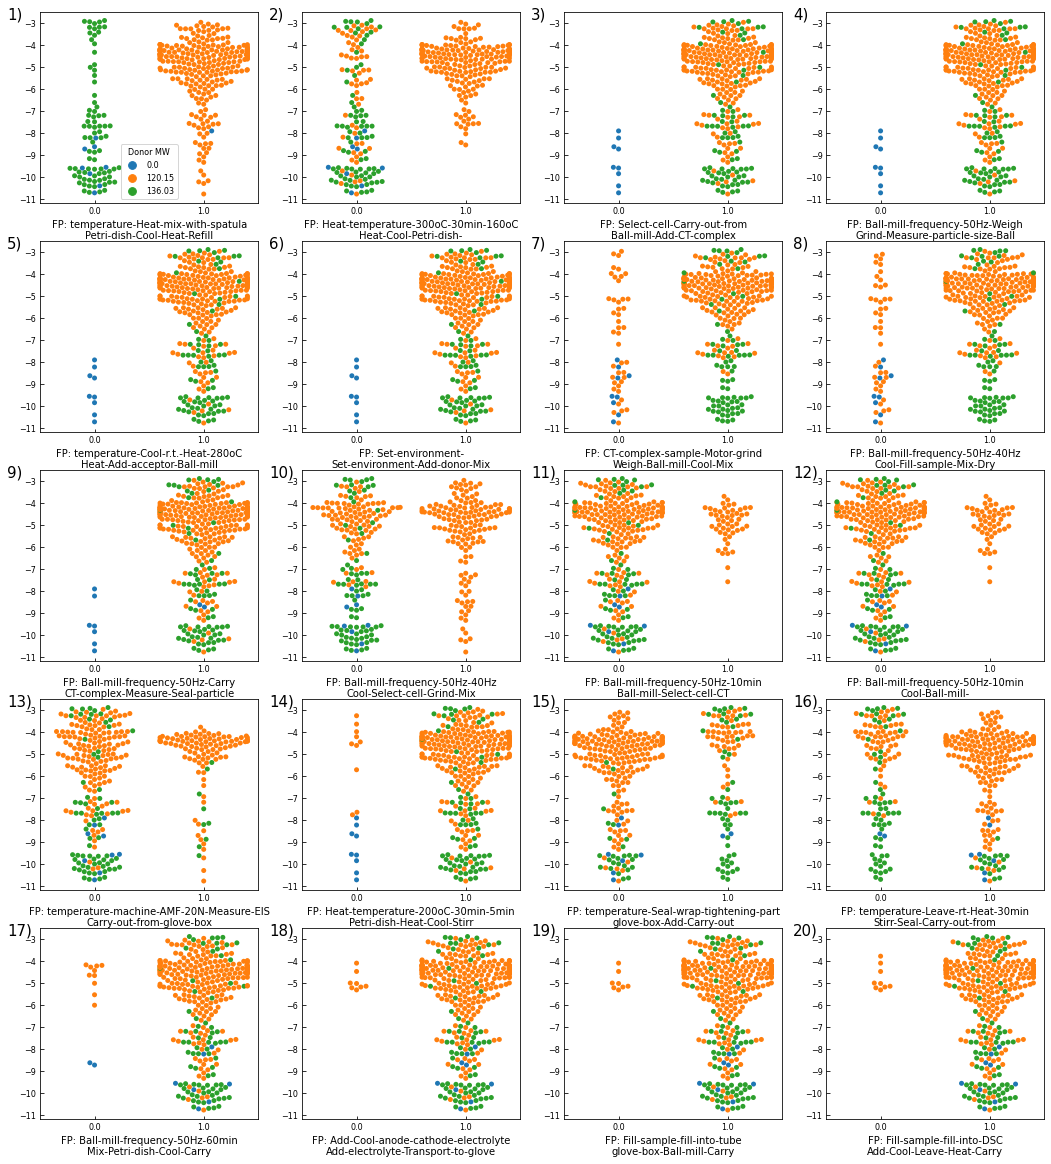

In [12]:
# conductivity versus various parameters

procedure_columns = ([i for i in imputed_df.columns if i.find("label") >= 0])
procedure_columns = ([i for i in imputed_df.columns if i.find("FP") >= 0])
procedure_columns.append(cond_label)
corr_df = (imputed_df[procedure_columns].corr()[
           cond_label]).sort_values(ascending=False)[1:]

sorted_procedure_columns = list(corr_df.index)
parameter_numbers = len(sorted_procedure_columns)
max_cols = 4
max_rows = math.ceil(parameter_numbers/max_cols)

proc_df = copy.copy(sigma_df)
proc_df = proc_df.fillna(0)

fig = plt.figure(figsize=(18, parameter_numbers*1.1))
plt.rcParams["font.size"] = 8


from string_parse import shorten_plotting_name

for i, col in enumerate(sorted_procedure_columns):
    ax = fig.add_subplot(max_rows, max_cols, i+1)
    sns.swarmplot(data=proc_df, x=col, y=cond_label, ax=ax, hue="Donor MW")
    x_name = shorten_plotting_name(col)

    # make new line for too long names
    spl_x_name = x_name.split(" ")
    if len(spl_x_name) > 8:
        x_name = ""
        for j, component in enumerate(spl_x_name):
            x_name += component+" "
            if j % 8 == 7:
                x_name += "\n"
        x_name = x_name.replace("\n\n", "\n")
        ax.set_xlabel(x_name, fontsize=9)
    else:
        ax.set_xlabel(x_name, fontsize=10)

    ax.text(-0.8, -2.8, f"{i+1})", size=15)
    ax.set_ylabel("")

    if i > 0:
        ax.get_legend().remove()
    if i == 19:
        break

''

<Figure size 500x900 with 0 Axes>

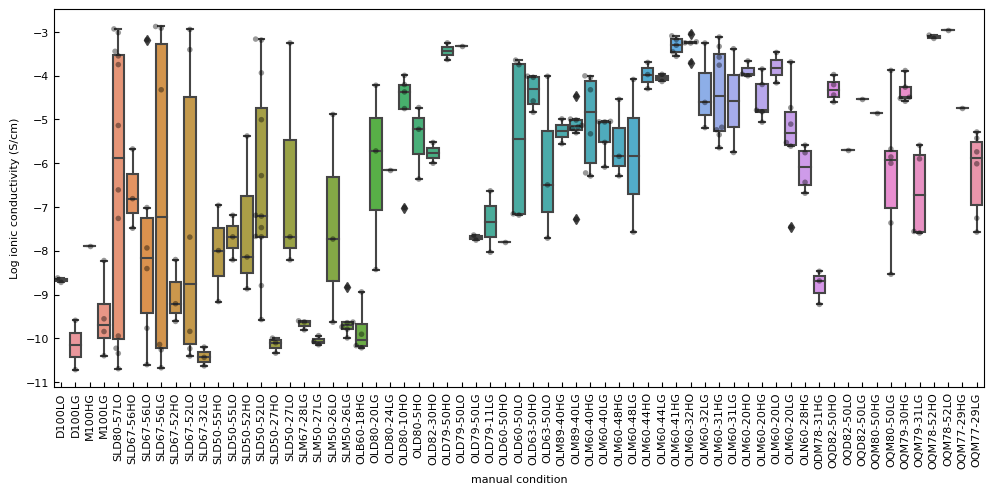

In [13]:
#box plot of conductivity for each electrolyte

plt.figure(figsize=(5, 9), dpi=100)
plt.rcParams["font.size"] = 8
plt.figure(figsize=(12, 5), dpi=100)
sns.swarmplot(data=anal_df_rt, x="manual condition",
              y=cond_label, color="black", s=4, alpha=0.4)
sns.boxplot(data=anal_df_rt, x="manual condition", y=cond_label)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
,

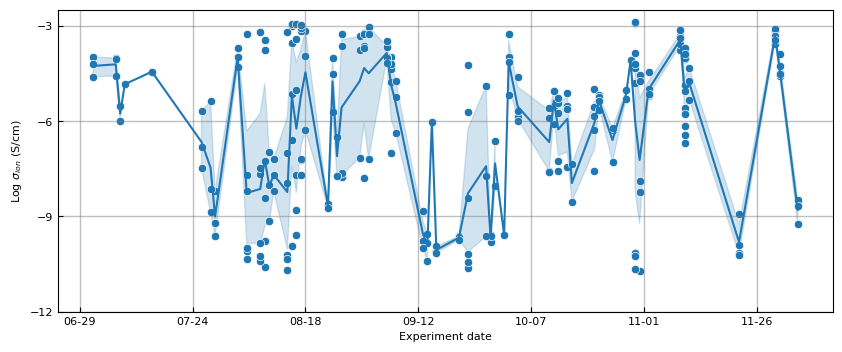

In [14]:
#date versus conductivity

import datetime
import matplotlib.dates as mdates

temp_plot_df = copy.copy(anal_df_rt)
temp_plot_df["Experiment date"] = temp_plot_df["2nd Day (unix)"].apply(
    datetime.datetime.fromtimestamp)

plt.figure(figsize=(10, 4), dpi=100)

ax = sns.lineplot(data=temp_plot_df, x="Experiment date", y=cond_label)
sns.scatterplot(data=temp_plot_df, x="Experiment date", y=cond_label, ax=ax)

daysFmt = mdates.DateFormatter('%m-%d')
ax.xaxis.set_major_formatter(daysFmt)  # x axis: date
days = mdates.DayLocator(bymonthday=None, interval=25, tz=None)
ax.xaxis.set_major_locator(days)
ax.set_ylabel(r'Log $\sigma$$_{ion}$ (S/cm)')
plt.yticks(np.arange(-12, -2, step=3))
plt.rcParams["font.size"] = 20
plt.grid(color='gray', linestyle='-', linewidth=1, alpha=0.5)

# Regression
- Predict conductivity from experimental data
    1) Extract essential parameters by boruta
    2) Prepare prediction model
    3) Evaluate importances by SHAP values

In [15]:
#from boruta import BorutaPy
from BorutaPyForLGB import BorutaPyForLGB
from machine_learning_util import auto_evaluation

#reg_columns=[i for i in anal_df.columns if i.find("name")<0]
reg_columns = []
reg_df = copy.copy(imputed_df)
reg_df = reg_df[reg_df[cond_label] == reg_df[cond_label]]

#Remove nonsense parameters and some paraemters to avoid problem leaking
nonsense_col_list = [
    "solid_NMR_Temperature",
    'DSC (sample amount)',
    'Donor amount (mg)',
    'Acceptor amount (mg)',
    'CT complex amount (mg)',
    "Formal salt ratio",
    'Salt amount (mg)',
    'DSC (salt_melting_temperature)',
    '1st Day (unix)',
    '2nd Day (unix)',
     'Dew point (1st day) ($^\\mathrm{o}$C)',
    'Dew point (2nd day) ($^\\mathrm{o}$C)',
    "O$_{2}$ (1st day) (ppm)",
    "O$_{2}$ (2nd day) (ppm)",
    "Cell ID"
    #"FP: Fill-sample-fill-into-Measure|Carry-out-from-glove-box", # this shold be removed because this relates to DSC, XRD measurements, etc
]
procedure_columns = ([i for i in imputed_df.columns if i.find("label") >= 0])
nonsense_col_list.extend(procedure_columns)
selected_reg_df = reg_df.drop(nonsense_col_list, axis=1)
#list(imputed_df.columns)

X = selected_reg_df.drop(cond_label, axis=1)
y = np.array(selected_reg_df[[cond_label]]).ravel()

# regression x Boruta
model=lgb.LGBMRegressor(num_leaves=20,max_bin=50)
feat_selector = BorutaPyForLGB(model, n_estimators='auto',
                               two_step=False,verbose=0, 
                               random_state=42,
                              alpha=0.05,
                              perc=60)

%time feat_selector.fit(X.values, y)

selected = feat_selector.support_
print('selected params: %d' % np.sum(selected))
print(X.columns[selected])

selected_X= X[X.columns[selected]]
selected_reg_df =copy.copy(selected_X)
selected_reg_df[cond_label] = y
# selected_reg_df.to_csv("temp/reg.csv")

CPU times: user 2min 1s, sys: 451 ms, total: 2min 2s
Wall time: 1.91 s
selected params: 13
Index(['FP: temperature-Seal-wrap-tightening-part|glove-box-Add-Carry-out',
       'Temperature of $\sigma$$_\mathrm{ion}$ ($^\mathrm{o}$C)',
       'Thickness ($\mu$m)', 'Donor ratio', 'Formal donor ratio',
       'Salt weight ratio', 'Date difference', 'Li(MAS): $\delta$ (ppm)',
       'Li(MAS): FWHM (ppm)', 'F(Static): FWHM (ppm)',
       'Li(Static): $\delta$ (ppm)', 'Li(Static): FWHM (ppm)',
       '$d_{50}$ ($\mu$m)'],
      dtype='object')


train R2:  0.8510609431688844
test R2:  0.4250653845505147


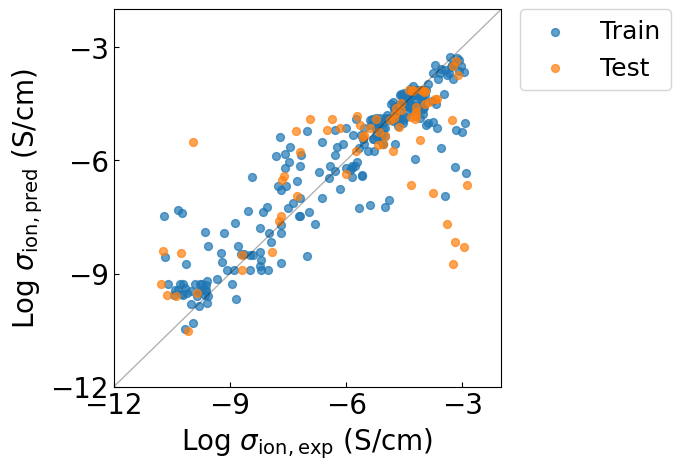

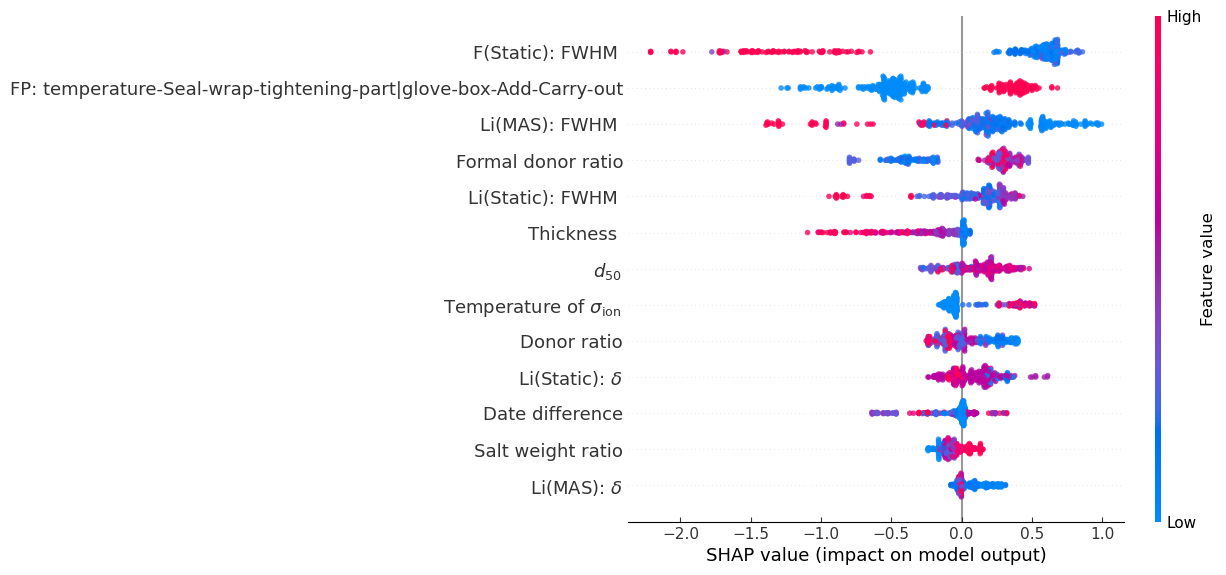

In [16]:
# init shapley module
import shap
from string_parse import shorten_column_name, shorten_column_name2
from string_parse import remove_json_characters


#rename dataframe for lightgbm
col_names=list(selected_reg_df.columns)
col_names=[remove_json_characters(i) for i in col_names]
renamed_selected_reg_df=copy.copy(selected_reg_df)
renamed_selected_reg_df.columns=col_names
renamed_cond_label=remove_json_characters(cond_label)

renamed_X=renamed_selected_reg_df.drop(renamed_cond_label,axis=1)
renamed_y=renamed_selected_reg_df[renamed_cond_label]


#auto regression
plt.rcParams["font.size"] = 20
auto_evaluation(renamed_selected_reg_df,renamed_cond_label,model=model)

#analyze shap
model.fit(renamed_X, renamed_y)
explainer = shap.TreeExplainer(model, data=(renamed_selected_reg_df))

plt.figure(dpi=100)
X_columns = [shorten_column_name(s) for s in list(selected_reg_df.columns)]
X_shap_values = explainer.shap_values(renamed_X, check_additivity=False)
shap.summary_plot(
    shap_values=X_shap_values,
    features=renamed_X,
    feature_names=X_columns,
    max_display=15,
    alpha=0.8
)



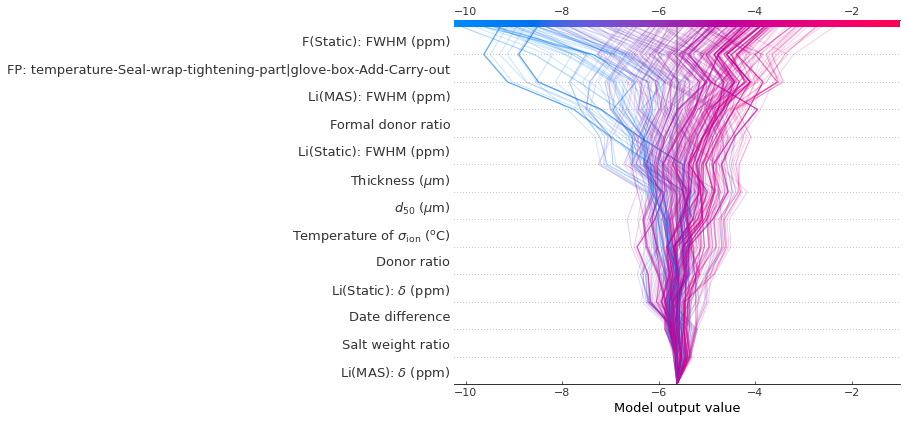

In [17]:
shap.decision_plot(base_value=explainer.expected_value,
                   shap_values=X_shap_values,
                   features=selected_X,
                   #feature_names=X_columns,
                   alpha=0.2,
                   )

<AxesSubplot:>

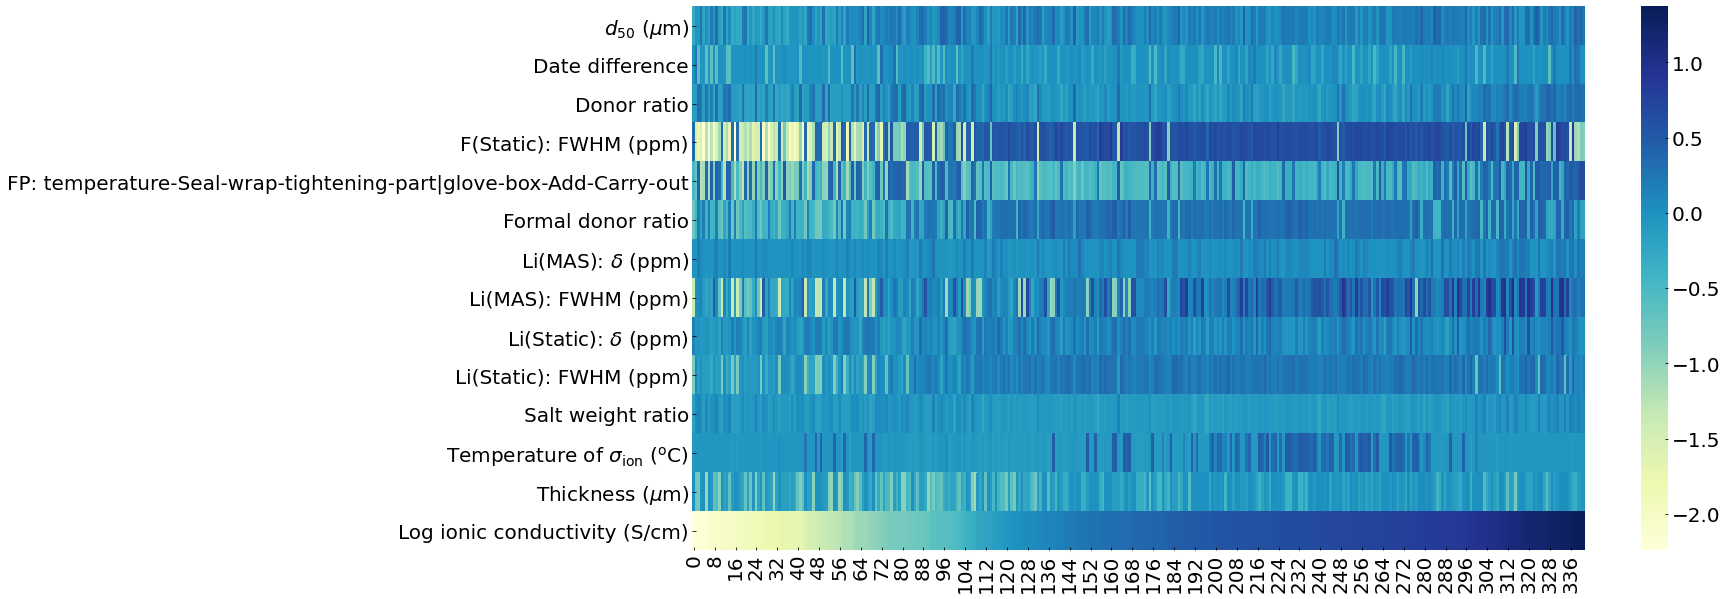

In [18]:
#heatmap with shap
from sklearn.preprocessing import StandardScaler

# shapley values
shap_df = pd.DataFrame(X_shap_values)
shap_df.columns = selected_reg_df.drop(cond_label, axis=1).columns
shap_df=shap_df.sort_index(axis=1)

# y
scaled_y = np.array(selected_reg_df[cond_label]).reshape(-1, 1)
scaled_y = StandardScaler().fit_transform(scaled_y)
shap_df[cond_label] = scaled_y
shap_df = shap_df.sort_values(by=cond_label)
shap_df = shap_df.reset_index(drop=True)
plt.figure(figsize=(20, 10))
sns.heatmap(data=shap_df.T, cmap="YlGnBu")

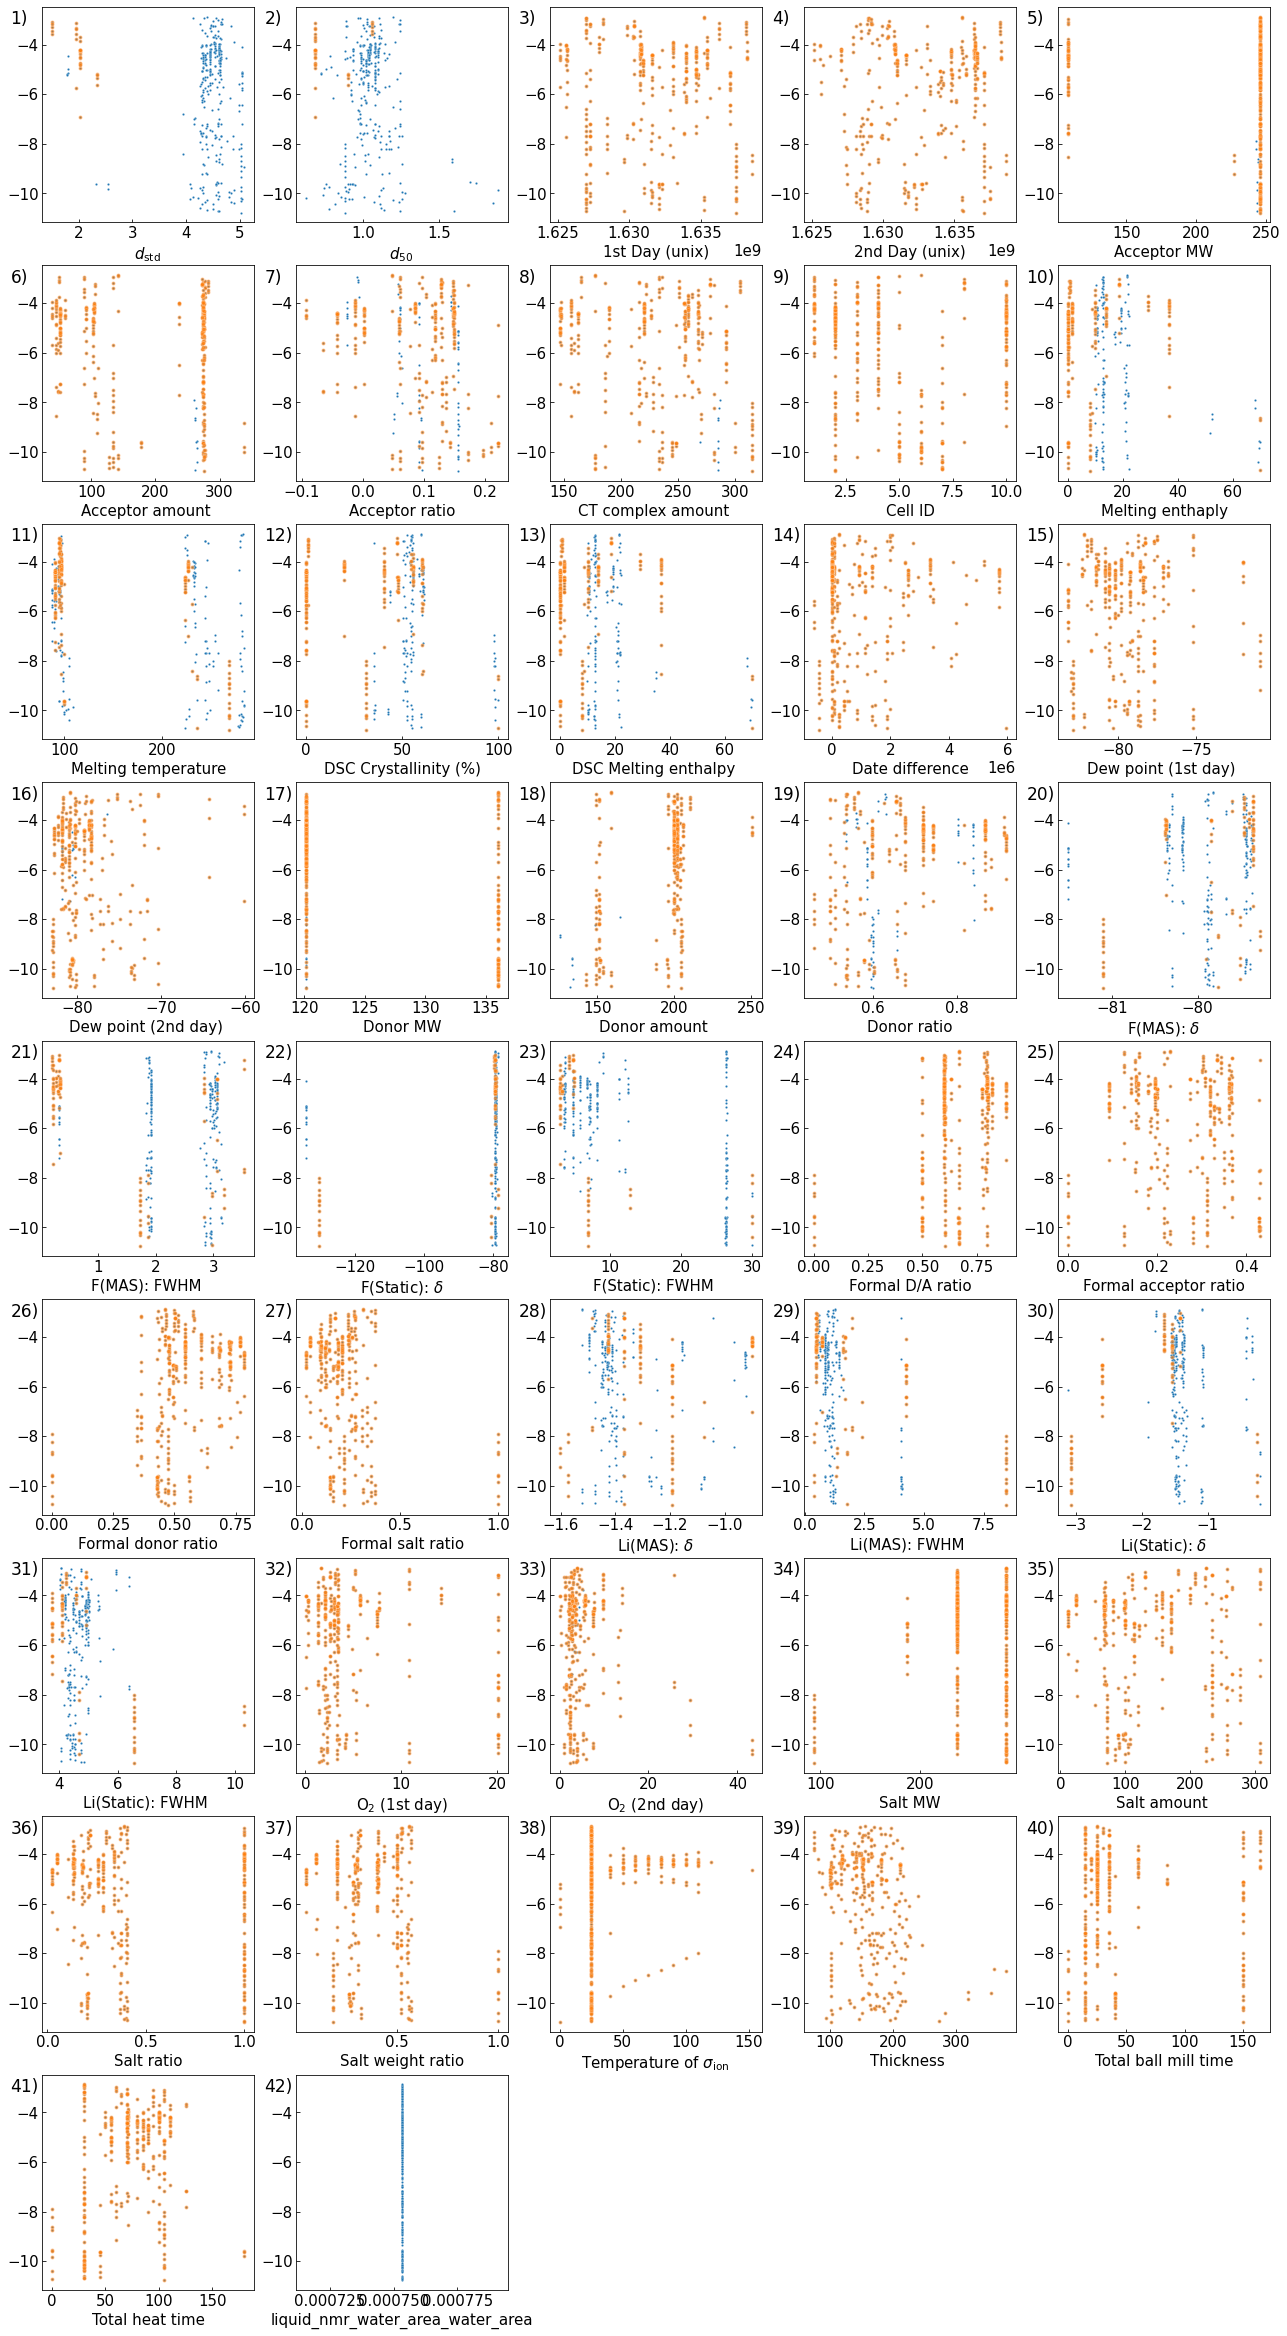

In [19]:
# plot relationshiops between sigma and other params
non_use_columns = [
    'donor_amount_MW',
    'donor_amount_Mw',
    'donor_amount_Mn',
    'acceptor_amount_MW',
    'salt_amount_MW',
    'particle_size_um_to_pixel',
    'solid_NMR_Temperature',
    'Anneal',
    'Vacuum pack',
    'Log ionic conductivity (S/cm)',
    "CT complex yield (mg)",
    'DSC (sample amount)',
]

plot_columns=[i for i in sigma_df.columns if i.find("label")<0]
plot_columns = [i for i in plot_columns if i.find("FP") < 0]
plot_columns = sorted([i for i in plot_columns if i not in non_use_columns])

parameter_numbers = len(plot_columns)
max_cols = 5
max_rows = math.ceil(parameter_numbers/max_cols)

plt.rcParams["font.size"] = 15
fig = plt.figure(figsize=(22, parameter_numbers))
for i, x in enumerate(plot_columns):
    ax = fig.add_subplot(max_rows, max_cols, i+1)
    if x.find("label") > 0 or x.find("FP") > 0:
        continue
    try:
        sns.scatterplot(data=imputed_df, x=x, y=cond_label, ax=ax, s=5)
    except:
        pass

    try:
        sns.scatterplot(data=sigma_df, x=x, y=cond_label,
                        ax=ax, s=15, alpha=0.6)
    except:
        pass
        print("error", x)

    ymin, ymax = ax.get_ylim()
    xmin, xmax = ax.get_xlim()

    scale_x = xmax-xmin
    scale_y = ymax-ymin
    posx = xmin-0.15*scale_x
    posy = ymax-0.08*scale_y
    ax.text(posx, posy, f"{i+1})", size=17, color="black")
    ax.set_ylabel("")
    ax.set_xlabel(shorten_column_name2(x), fontsize=15)
    # break
    # if i==10:
    #    break

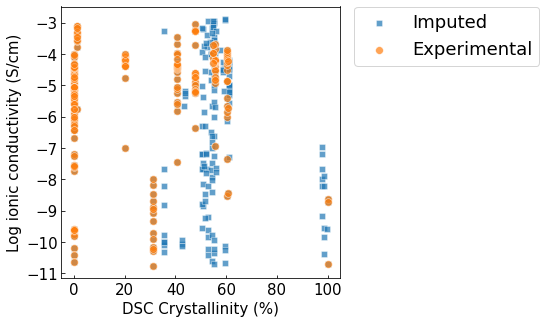

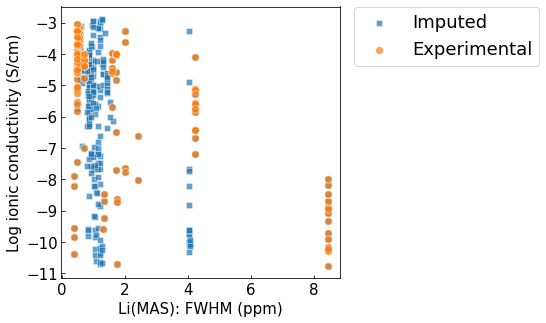

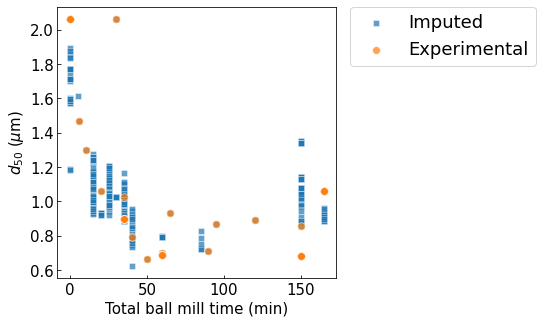

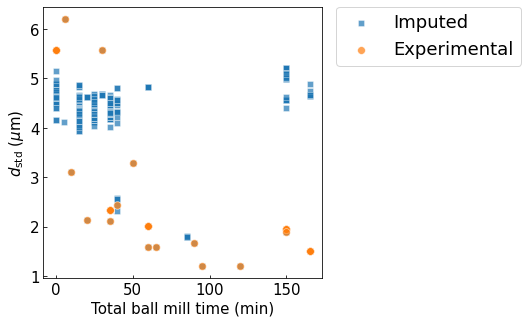

In [20]:
# larget plot for interested params
plt.rcParams["font.size"] = 15

plot_label_list = [
    [sigma_df, "DSC Crystallinity (%)", cond_label],
    [sigma_df, 'Li(MAS): FWHM (ppm)', cond_label],
    [df, "Total ball mill time (min)", "$d_{50}$ ($\mu$m)"],
    [df, "Total ball mill time (min)", "$d_\mathrm{std}$ ($\mu$m)"],
    
]

for current_df, current_x_label, current_y_label in plot_label_list:
    plt.figure(figsize=(5, 5))
    sns.scatterplot(data=imputed_df, x=current_x_label,
                    y=current_y_label, s=40, alpha=0.7, label="Imputed", marker="s")
    sns.scatterplot(data=current_df, x=current_x_label,
                    y=current_y_label, s=60, alpha=0.7, label="Experimental")
    plt.xlabel(current_x_label)

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',
               borderaxespad=0, fontsize=18)

Text(0.5, 0, 'Add donor')

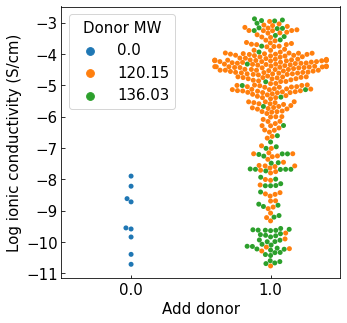

In [21]:
plt.figure(figsize=(5, 5))
x = 'label: Add donor, type: sample, <-->Mix'
sns.swarmplot(data=proc_df, x=x, y=cond_label, hue="Donor MW")
plt.xlabel("Add donor")

# Visualize temperature dependence

<AxesSubplot:xlabel='1000/T (K)', ylabel='Log ionic conductivity (S/cm)'>

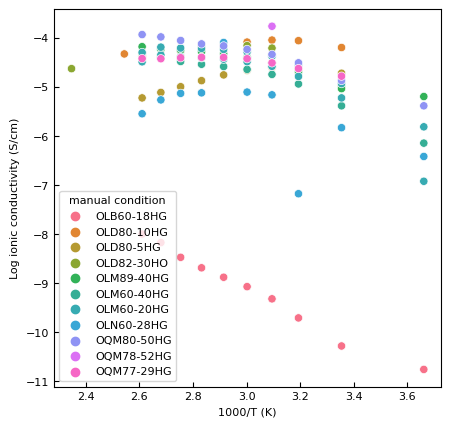

In [22]:
temperature_label = "Temperature of $\sigma$$_\mathrm{ion}$ ($^\mathrm{o}$C)"
temperature_df = anal_df[anal_df[temperature_label] != 25.01]
temperature_df = temperature_df[temperature_df[temperature_label]
                                == temperature_df[temperature_label]]
temperature_df["1000/T (K)"] = 1000/(temperature_df[temperature_label]+273.15)

plt.rcParams["font.size"] = 8
plt.figure(figsize=(5, 5), dpi=100)

# for acceptor_mw in set(temperature_df["Acceptor MW"]):

sns.scatterplot(data=temperature_df, x="1000/T (K)",
                y=cond_label, hue="manual condition")

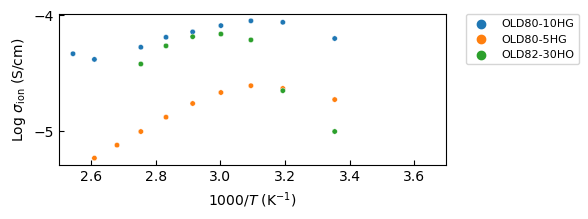

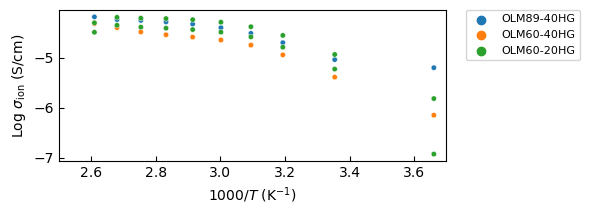

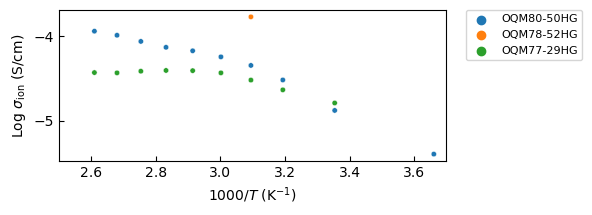

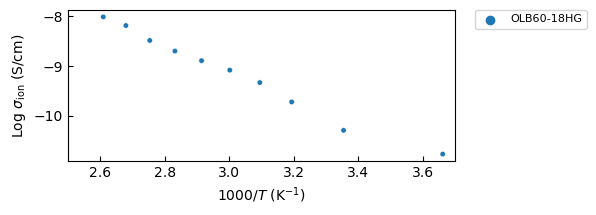

In [23]:
import matplotlib.ticker as ticker

plt.rcParams["font.size"] = 10

electrolyte_list = ["OLD", "OLM", "OQM", "OLB"]
for cond in (electrolyte_list):
    plt.figure(figsize=(5, 2), dpi=100)
    ax = plt.gca()
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    sel_df = temperature_df[temperature_df["manual condition"].str.contains(
        cond) > 0]
    sns.scatterplot(data=sel_df, x="1000/T (K)", y=cond_label,
                    hue="manual condition", s=15, ax=ax)  # ,color=color)
    plt.xlim(2.5, 3.7)
    # plt.ylim(-8,-3)
    plt.ylabel("Log $\sigma$$_\mathrm{ion}$ (S/cm)")
    plt.xlabel("1000/$T$ (K$^{-1}$)")

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',
               borderaxespad=0, fontsize=8)
#sns.scatterplot(data=temperature_df,x="1000/T (K)",y=cond_label,hue="manual condition")

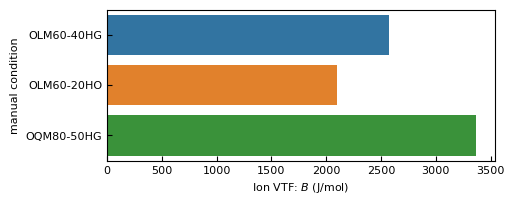

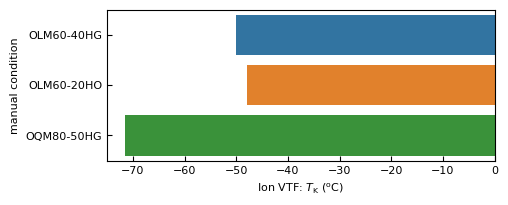

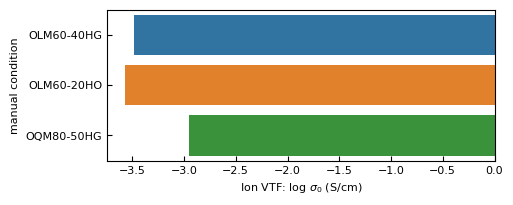

In [24]:
plt.rcParams["font.size"] = 8

x_labels = [
    "Ion VTF: $B$ (J/mol)",
    "Ion VTF: $T_\mathrm{K}$ ($^\mathrm{o}$C)",
    "Ion VTF: log $\\sigma_{0}$ (S/cm)"
]

for x_label in x_labels:
    plt.figure(figsize=(5, 2), dpi=100)
    plot_df = copy.copy(anal_df_rt)
    plot_df[x_label] = num_df[x_label]
    pot_df = plot_df[plot_df[x_label] == plot_df[x_label]]
    pot_df = pot_df.drop_duplicates(subset=["manual condition"])
    pot_df = pot_df.drop_duplicates(subset=[x_label])
    sns.barplot(data=pot_df, y="manual condition", x=x_label)

# Causal analysis

In [25]:
from causalnex.structure.notears import from_pandas, from_pandas_lasso
import networkx as nx

In [26]:
sel_columns = [
    cond_label,
    'Formal D/A ratio',
    'Salt weight ratio',
    #'Li(MAS): FWHM (ppm)',
    'F(MAS): FWHM (ppm)',
    'DSC Crystallinity (%)',
]
sel_df = copy.copy(reg_df[sel_columns])
sel_df

,Log ionic conductivity (S/cm),Formal D/A ratio,Salt weight ratio,F(MAS): FWHM (ppm),DSC Crystallinity (%)
normal_experiment0_graph_integrated_json_0_database/experiments/HA/exp150_eis_s86_pmps_chloranil_litfsi/exp150_eis.graphml,-6.809668,0.667528,0.556192,2.762571,54.396255
normal_experiment0_graph_integrated_json_1_database/experiments/HA/exp150_eis_s86_pmps_chloranil_litfsi/exp150_eis.graphml,-7.485452,0.667528,0.556192,2.872122,54.396255
normal_experiment0_graph_integrated_json_2_database/experiments/HA/exp150_eis_s86_pmps_chloranil_litfsi/exp150_eis.graphml,-5.673664,0.667528,0.556192,2.872122,54.385418
normal_experiment1_graph_integrated_json_0_database/experiments/HA/exp151_eis_s87_pmps_chloranil_litfsi/exp151.graphml,-8.869666,0.498777,0.519385,1.823440,50.774548
normal_experiment1_graph_integrated_json_1_database/experiments/HA/exp151_eis_s87_pmps_chloranil_litfsi/exp151.graphml,-8.142668,0.498777,0.519385,1.830685,50.774548
...,...,...,...,...,...
normal_experiment170_graph_integrated_json_1_database/experiments/MU/normal/913_ppo_chloranil_litfsi/913.graphml,-8.428291,0.798928,0.203887,2.948475,60.605736
normal_experiment170_graph_integrated_json_2_database/experiments/MU/normal/913_ppo_chloranil_litfsi/913.graphml,-5.718967,0.798928,0.203887,2.945482,60.605736
normal_experiment171_graph_integrated_json_0_database/experiments/MU/normal/915_ppo_bq_liftfsi_sample/915.graphml,-6.012781,0.774978,0.294399,2.973684,0.000000
normal_experiment172_graph_integrated_json_0_database/experiments/MU/normal/929_ppo_chloranil_litfsi/929.graphml,-8.033858,0.787557,0.105068,3.131212,54.514854


In [27]:
%time causal = from_pandas(sel_df)

CPU times: user 52.9 s, sys: 999 ms, total: 53.9 s
Wall time: 845 ms


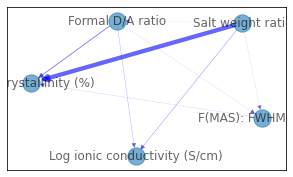

In [28]:
from pyvis.network import Network

copy_sm = causal.copy()
copy_sm.remove_edges_below_threshold(0.5)


plt.figure(figsize=(5, 3))
pos = nx.spring_layout(copy_sm, k=60)
nx.draw_networkx(copy_sm,
                 pos,
                 arrowsize=10,
                 alpha=0.6,
                 edge_color='b',
                 width=[d['weight'] *
                        0.06 for (u, v, d) in copy_sm.edges(data=True)]
                 )

# save html file
g = causal.copy()
g.remove_edges_below_threshold(1.5)
pyvis_g = Network(directed=True)
for edge in (g.edges(data=True)):
    # edge width
    edge[-1]["width"] = (edge[-1]["weight"]/20)
    # edge color
    if edge[-1]["width"] > 0:
        edge[-1]["color"] = "blue"
    else:
        edge[-1]["color"] = "red"

    # edge label
    weight = "{:.2g}".format(edge[-1]["weight"])
    edge[-1]["label"] = f"{weight}"

pyvis_g.from_nx(g)
pyvis_g.show_buttons()
pyvis_g.show("temp/causal_anal.html")

# draw flowchart for an experimental data

In [29]:
from visualize_graph import save_graph_html

#select one graph
experiment_list = list(sigma_df.sort_values(
    by=cond_label, ascending=False).index)

target_graph_label = experiment_list[-7]
fc_g = copy.copy(experiment_manager.selected_graph_dict[target_graph_label])
print(target_graph_label)

#save as html
save_graph_html(fc_g)

normal_experiment25_graph_integrated_json_1_database/experiments/HA/exp200_eis_pmps_chloranil_litfsi/exp200_eis.graphml
